In [ ]:
import os
import random
import numpy as np
import tensorflow as tf

def seed_everything(seed=42):
    os.environ["PYTHONHASHSEED"] = str(seed)
    os.environ["TF_DETERMINISTIC_OPS"] = "1"
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
seed_everything(42)


# Import Necessary Libraries

In [ ]:
!pip install optuna
!pip install optuna-integration

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 413.9/413.9 kB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 kB 4.0 MB/s eta 0:00:00


# IMPORT LIBRARIES

In [ ]:
# IMPORT LIBRARIES
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import optuna
import tensorflow as tf

from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from tensorflow.keras.backend import clear_session

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Conv1D, Dense,Flatten, Dropout
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
import warnings  # Warning control
warnings.filterwarnings("ignore")

# Import Data

In [ ]:

file_id = "1EIEsAzVWCwsAiOIO190r3g4mVCleNoNs"
csv_url = f"https://drive.google.com/uc?id={file_id}"

# Read the Google Drive file as CSV
df = pd.read_csv(csv_url)

# Backup original DataFrame
df_backup = df.copy()

# Set Date as the index (ensure column name matches your file)
df['Date'] = pd.to_datetime(df['Date'])
df = df.set_index('Date')

# Display first few tourism demand
df.head()

# Backup
df_backup = df.copy()


In [ ]:
df.head()

,Cluster_1,Cluster_2,Cluster_3,Cluster_4,Cluster_5,Cluster_6,Positive,Neutral,Negative,Total Tourist Arrivals,Sri Lanka Hotels,Sri Lanka Flights,Sri Lanka Visa
Date,,,,,,,,,,,,,
2006-01-01,0,0,0,0,0,0,0,0,0,52103,49,29,0
2006-02-01,1,0,0,0,0,1,0,2,0,52687,41,20,0
2006-03-01,1,0,2,0,1,0,1,3,0,54746,35,20,47
2006-04-01,0,1,2,0,1,1,0,4,1,49776,38,20,0
2006-05-01,3,1,1,5,0,1,4,3,4,43825,34,16,0


In [ ]:
df.columns.to_list()

['Cluster_1',
 'Cluster_2',
 'Cluster_3',
 'Cluster_4',
 'Cluster_5',
 'Cluster_6',
 'Positive',
 'Neutral',
 'Negative',
 'Total Tourist Arrivals',
 'Sri Lanka Hotels',
 'Sri Lanka Flights',
 'Sri Lanka Visa']

# Drop Google Trends

In [ ]:
df.drop(['Sri Lanka Hotels',
 'Sri Lanka Flights',
 'Sri Lanka Visa'], axis=1, inplace=True)

# Pre Processing

In [ ]:
# maximum lag length
max_laglength = 1

# Backup
df_backup = df.copy()

# Create lags
for lag in range(1, max_laglength+1):
    for col in df_backup.columns.to_list():
        df[f"{col}(t-{lag})"] = df[col].shift(lag)

# -----------------------------
# Add month as categorical
# -----------------------------
df["Month"] = df.index.month_name()
df = pd.get_dummies(df, columns=["Month"], prefix="month")

# -----------------------------
# Drop original t=0 variables (optional)
# -----------------------------
cols_to_drop = [
    'Cluster_1', 'Cluster_2', 'Cluster_3', 'Cluster_4',
    'Cluster_5', 'Cluster_6', 'Positive', 'Neutral', 'Negative'
]
df.drop(columns=cols_to_drop, inplace=True, errors='ignore')

# -----------------------------
# Drop rows with NaNs created by lagging
# -----------------------------
df.dropna(inplace=True)

# -----------------------------
# Check
# -----------------------------
df.head()




,Total Tourist Arrivals,Cluster_1(t-1),Cluster_2(t-1),Cluster_3(t-1),Cluster_4(t-1),Cluster_5(t-1),Cluster_6(t-1),Positive(t-1),Neutral(t-1),Negative(t-1),...,month_December,month_February,month_January,month_July,month_June,month_March,month_May,month_November,month_October,month_September
Date,,,,,,,,,,,,,,,,,,,,,
2006-02-01,52687,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,False,True,False,False,False,False,False,False,False,False
2006-03-01,54746,1.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,0.0,...,False,False,False,False,False,True,False,False,False,False
2006-04-01,49776,1.0,0.0,2.0,0.0,1.0,0.0,1.0,3.0,0.0,...,False,False,False,False,False,False,False,False,False,False
2006-05-01,43825,0.0,1.0,2.0,0.0,1.0,1.0,0.0,4.0,1.0,...,False,False,False,False,False,False,True,False,False,False
2006-06-01,44066,3.0,1.0,1.0,5.0,0.0,1.0,4.0,3.0,4.0,...,False,False,False,False,True,False,False,False,False,False


In [ ]:
df.columns.to_list()

['Total Tourist Arrivals',
 'Cluster_1(t-1)',
 'Cluster_2(t-1)',
 'Cluster_3(t-1)',
 'Cluster_4(t-1)',
 'Cluster_5(t-1)',
 'Cluster_6(t-1)',
 'Positive(t-1)',
 'Neutral(t-1)',
 'Negative(t-1)',
 'Total Tourist Arrivals(t-1)',
 'month_April',
 'month_August',
 'month_December',
 'month_February',
 'month_January',
 'month_July',
 'month_June',
 'month_March',
 'month_May',
 'month_November',
 'month_October',
 'month_September']

# Train Test Split

In [ ]:
target = "Total Tourist Arrivals"

# Ensure chronological order
df = df.sort_index()   # index should be datetime

# Define forecast horizon
forecast_horizon = 12  # last 12 months

# Split data
train = df.iloc[:-forecast_horizon]
test  = df.iloc[-forecast_horizon:]

# Separate features and target
X_train = train.drop(columns=[target])
y_train = train[target]

X_test = test.drop(columns=[target])
y_test = test[target]

print(f"Train size: {len(train)}")
print(f"Test size (last 12 months): {len(test)}")


Train size: 224
Test size (last 12 months): 12


# Moving Window

In [ ]:
# MOVING WINDOW APPROACH
tscv = TimeSeriesSplit(
    n_splits=5

)

# XGB Feature Selection

In [ ]:
# XGBOOST

# -----------------------------
# objective
# -----------------------------
def objective(trial):

    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 500),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
        "random_state": 42
    }

    fold_scores = []

    for train_idx, val_idx in tscv.split(X_train):
        X_t, y_t = X_train.iloc[train_idx], y_train.iloc[train_idx]
        X_v, y_v = X_train.iloc[val_idx], y_train.iloc[val_idx]

        model = XGBRegressor(**params)
        model.fit(X_t, y_t)

        pred = model.predict(X_v)
        fold_scores.append(mean_squared_error(y_v, pred))

    return np.mean(fold_scores)
# -----------------------------
# Run optimization
# -----------------------------
study_xgboost = optuna.create_study(direction="minimize",  sampler=optuna.samplers.TPESampler(seed=42))
study_xgboost.optimize(objective, n_trials=100)
best_params_xgboost = study_xgboost.best_params

# -----------------------------
# Fit XGBOOST
# -----------------------------
xgb_model = XGBRegressor(**best_params_xgboost, random_state=42)
xgb_model.fit(X_train, y_train)


# Metrics
# -----------------------------
# TRAIN PREDICTIONS & METRICS
# -----------------------------
train_pred = xgb_model.predict(X_train)

train_mse = mean_squared_error(y_train, train_pred)
train_rmse = np.sqrt(train_mse)
train_mae = mean_absolute_error(y_train, train_pred)
train_mape = mean_absolute_percentage_error(y_train, train_pred)
train_r2 = r2_score(y_train, train_pred)

print("==== TRAIN METRICS ====")
print("Train MSE :", train_mse)
print("Train RMSE:", train_rmse)
print("Train MAE :", train_mae)
print("Train MAPE:", train_mape)
print("Train R²  :", train_r2)

# -----------------------------
# TEST PREDICTIONS & METRICS
# -----------------------------
test_pred = xgb_model.predict(X_test)

test_mse = mean_squared_error(y_test, test_pred)
test_rmse = np.sqrt(test_mse)
test_mae = mean_absolute_error(y_test, test_pred)
test_mape = mean_absolute_percentage_error(y_test, test_pred)
test_r2 = r2_score(y_test, test_pred)

print("\n==== TEST METRICS ====")
print("Test MSE :", test_mse)
print("Test RMSE:", test_rmse)
print("Test MAE :", test_mae)
print("Test MAPE:", test_mape)
print("Test R²  :", test_r2)

[I 2026-02-04 05:54:09,032] A new study created in memory with name: no-name-d61681e8-167b-4ff8-8cb9-19cefcd0e299
[I 2026-02-04 05:54:16,142] Trial 0 finished with value: 2430428377.6 and parameters: {'n_estimators': 250, 'max_depth': 10, 'learning_rate': 0.22227824312530747, 'subsample': 0.8394633936788146, 'colsample_bytree': 0.6624074561769746}. Best is trial 0 with value: 2430428377.6.
[I 2026-02-04 05:54:17,761] Trial 1 finished with value: 1501585465.6 and parameters: {'n_estimators': 162, 'max_depth': 3, 'learning_rate': 0.2611910822747312, 'subsample': 0.8404460046972835, 'colsample_bytree': 0.8832290311184181}. Best is trial 1 with value: 1501585465.6.
[I 2026-02-04 05:54:19,674] Trial 2 finished with value: 2465005171.2 and parameters: {'n_estimators': 108, 'max_depth': 10, 'learning_rate': 0.2514083658321223, 'subsample': 0.6849356442713105, 'colsample_bytree': 0.6727299868828402}. Best is trial 1 with value: 1501585465.6.
[I 2026-02-04 05:54:21,570] Trial 3 finished with va

==== TRAIN METRICS ====
Train MSE : 0.0001411518460372463
Train RMSE: 0.011880734238137233
Train MAE : 0.008332501165568829
Train MAPE: 490135027712.0
Train R²  : 1.0

==== TEST METRICS ====
Test MSE : 748116736.0
Test RMSE: 27351.722724537845
Test MAE : 21639.509765625
Test MAPE: 0.11789008975028992
Test R²  : 0.5861278176307678


### Feature Importance Plot

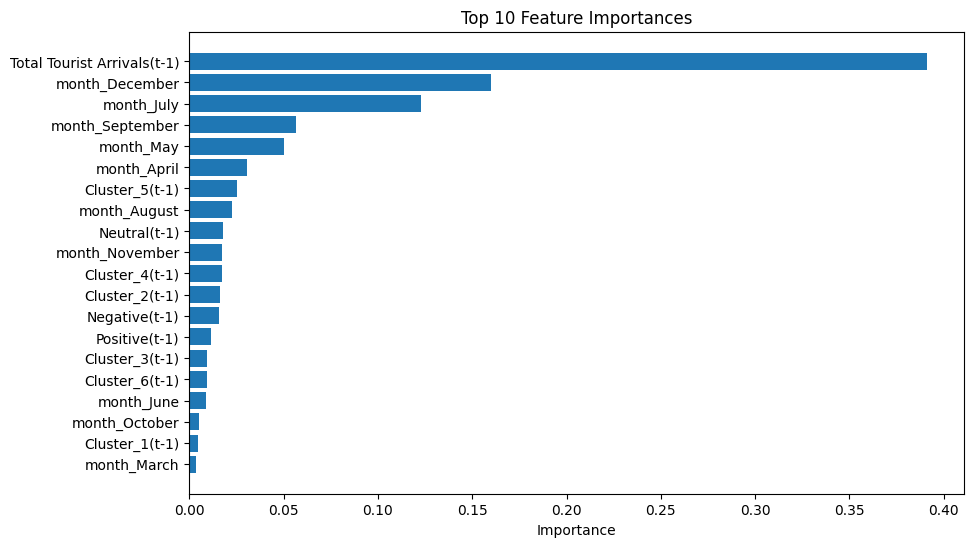

In [ ]:
# IMPORTANCE GRAPH
model = xgb_model

# Extract feature importances
importances = model.feature_importances_
feature_names = X_train.columns

# Convert to DataFrame
imp_df = pd.DataFrame({
    "feature": feature_names,
    "importance": importances
})


# Sort & select top 10
top20 = imp_df.sort_values(by="importance", ascending=False).head(20)


# Plot
plt.figure(figsize=(10, 6))
plt.barh(top20["feature"], top20["importance"])
plt.gca().invert_yaxis()  # highest at top
plt.xlabel("Importance")
plt.title("Top 10 Feature Importances")
plt.show()

In [ ]:
X_train.columns

Index(['Cluster_1(t-1)', 'Cluster_2(t-1)', 'Cluster_3(t-1)', 'Cluster_4(t-1)',
       'Cluster_5(t-1)', 'Cluster_6(t-1)', 'Positive(t-1)', 'Neutral(t-1)',
       'Negative(t-1)', 'Total Tourist Arrivals(t-1)', 'month_April',
       'month_August', 'month_December', 'month_February', 'month_January',
       'month_July', 'month_June', 'month_March', 'month_May',
       'month_November', 'month_October', 'month_September'],
      dtype='object')

## Best Elbow

In [ ]:
import numpy as np

elbow_points = np.array([1, 2, 3, 4, 5, 6, 7, 8, 13, 17, 20])
# Compute differences
diff = np.diff(elbow_points)

# Largest jump → elbow
elbow_index = np.argmax(diff)
best_elbow_point = elbow_points[elbow_index]

print("Best elbow point:", best_elbow_point)

Best elbow point: 8


[I 2026-02-04 05:56:18,345] A new study created in memory with name: no-name-4a4c8e95-6120-4f2d-892e-86198aea8448



========== TUNING FOR TOP 1 FEATURES ==========


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2026-02-04 05:56:23,176] Trial 0 finished with value: 1638895603.2 and parameters: {'n_estimators': 749, 'max_depth': 10, 'learning_rate': 0.1205712628744377, 'subsample': 0.8394633936788146, 'colsample_bytree': 0.6624074561769746, 'gamma': 0.7799726016810132, 'min_child_weight': 1, 'reg_alpha': 4.330880728874676, 'reg_lambda': 3.005575058716044}. Best is trial 0 with value: 1638895603.2.
[I 2026-02-04 05:56:23,926] Trial 1 finished with value: 1745560736.0 and parameters: {'n_estimators': 1150, 'max_depth': 2, 'learning_rate': 0.2708160864249968, 'subsample': 0.9329770563201687, 'colsample_bytree': 0.6849356442713105, 'gamma': 0.9091248360355031, 'min_child_weight': 2, 'reg_alpha': 1.5212112147976886, 'reg_lambda': 2.6237821581611893}. Best is trial 0 with value: 1638895603.2.
[I 2026-02-04 05:56:24,682] Trial 2 finished with value: 1764131340.8 and parameters: {'n_estimators': 818, 'max_depth': 4, 'learning_rate': 0.08012737503998542, 'subsample': 0.6557975442608167, 'colsample_by

[I 2026-02-04 05:57:26,461] A new study created in memory with name: no-name-383a52aa-0e18-4eef-88ec-6dcdae5dabd4


[I 2026-02-04 05:57:26,263] Trial 49 finished with value: 1622254758.4 and parameters: {'n_estimators': 982, 'max_depth': 4, 'learning_rate': 0.020763919106182516, 'subsample': 0.9222835120678594, 'colsample_bytree': 0.6514606515567132, 'gamma': 0.706317988264963, 'min_child_weight': 4, 'reg_alpha': 1.3483929733774715, 'reg_lambda': 2.2293019494834447}. Best is trial 42 with value: 1517005350.4.
Best Parameters: {'n_estimators': 1193, 'max_depth': 2, 'learning_rate': 0.011368075157277925, 'subsample': 0.9593448663341314, 'colsample_bytree': 0.6544970138389044, 'gamma': 1.5801345264688196, 'min_child_weight': 1, 'reg_alpha': 0.32735176437714264, 'reg_lambda': 0.5179735849436131}

========== TUNING FOR TOP 2 FEATURES ==========


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2026-02-04 05:57:27,670] Trial 0 finished with value: 1545222860.8 and parameters: {'n_estimators': 749, 'max_depth': 10, 'learning_rate': 0.1205712628744377, 'subsample': 0.8394633936788146, 'colsample_bytree': 0.6624074561769746, 'gamma': 0.7799726016810132, 'min_child_weight': 1, 'reg_alpha': 4.330880728874676, 'reg_lambda': 3.005575058716044}. Best is trial 0 with value: 1545222860.8.
[I 2026-02-04 05:57:29,087] Trial 1 finished with value: 1634343084.8 and parameters: {'n_estimators': 1150, 'max_depth': 2, 'learning_rate': 0.2708160864249968, 'subsample': 0.9329770563201687, 'colsample_bytree': 0.6849356442713105, 'gamma': 0.9091248360355031, 'min_child_weight': 2, 'reg_alpha': 1.5212112147976886, 'reg_lambda': 2.6237821581611893}. Best is trial 0 with value: 1545222860.8.
[I 2026-02-04 05:57:30,510] Trial 2 finished with value: 1629865523.2 and parameters: {'n_estimators': 818, 'max_depth': 4, 'learning_rate': 0.08012737503998542, 'subsample': 0.6557975442608167, 'colsample_by

[I 2026-02-04 05:58:06,687] A new study created in memory with name: no-name-78d1c3bc-4007-4356-abd0-8bbb995f65a6


[I 2026-02-04 05:58:06,586] Trial 49 finished with value: 1552804153.6 and parameters: {'n_estimators': 1087, 'max_depth': 3, 'learning_rate': 0.047041882362111626, 'subsample': 0.8649097571211413, 'colsample_bytree': 0.6746158920871179, 'gamma': 2.8547835689474836, 'min_child_weight': 6, 'reg_alpha': 1.6313187789293622, 'reg_lambda': 1.598615845253045}. Best is trial 12 with value: 1405713433.6.
Best Parameters: {'n_estimators': 502, 'max_depth': 2, 'learning_rate': 0.03163393826748552, 'subsample': 0.9943435740037198, 'colsample_bytree': 0.8384389352084881, 'gamma': 2.9005404163726607, 'min_child_weight': 1, 'reg_alpha': 2.9020226051267786, 'reg_lambda': 0.017902345021022392}

========== TUNING FOR TOP 3 FEATURES ==========


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2026-02-04 05:58:07,691] Trial 0 finished with value: 1437687648.0 and parameters: {'n_estimators': 749, 'max_depth': 10, 'learning_rate': 0.1205712628744377, 'subsample': 0.8394633936788146, 'colsample_bytree': 0.6624074561769746, 'gamma': 0.7799726016810132, 'min_child_weight': 1, 'reg_alpha': 4.330880728874676, 'reg_lambda': 3.005575058716044}. Best is trial 0 with value: 1437687648.0.
[I 2026-02-04 05:58:08,533] Trial 1 finished with value: 1406869388.8 and parameters: {'n_estimators': 1150, 'max_depth': 2, 'learning_rate': 0.2708160864249968, 'subsample': 0.9329770563201687, 'colsample_bytree': 0.6849356442713105, 'gamma': 0.9091248360355031, 'min_child_weight': 2, 'reg_alpha': 1.5212112147976886, 'reg_lambda': 2.6237821581611893}. Best is trial 1 with value: 1406869388.8.
[I 2026-02-04 05:58:09,248] Trial 2 finished with value: 1487876787.2 and parameters: {'n_estimators': 818, 'max_depth': 4, 'learning_rate': 0.08012737503998542, 'subsample': 0.6557975442608167, 'colsample_by

[I 2026-02-04 05:58:49,338] A new study created in memory with name: no-name-3ae5d601-d4d5-4be8-b01c-33690d5f74d6


[I 2026-02-04 05:58:49,242] Trial 49 finished with value: 1406547065.6 and parameters: {'n_estimators': 623, 'max_depth': 3, 'learning_rate': 0.05067215040369738, 'subsample': 0.8622187118198226, 'colsample_bytree': 0.7973608224614732, 'gamma': 0.8524643351370964, 'min_child_weight': 6, 'reg_alpha': 2.6858480067991346, 'reg_lambda': 1.062645694796292}. Best is trial 12 with value: 1229480672.0.
Best Parameters: {'n_estimators': 502, 'max_depth': 2, 'learning_rate': 0.03163393826748552, 'subsample': 0.9943435740037198, 'colsample_bytree': 0.8384389352084881, 'gamma': 2.9005404163726607, 'min_child_weight': 1, 'reg_alpha': 2.9020226051267786, 'reg_lambda': 0.017902345021022392}

========== TUNING FOR TOP 4 FEATURES ==========


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2026-02-04 05:58:50,469] Trial 0 finished with value: 1366502041.6 and parameters: {'n_estimators': 749, 'max_depth': 10, 'learning_rate': 0.1205712628744377, 'subsample': 0.8394633936788146, 'colsample_bytree': 0.6624074561769746, 'gamma': 0.7799726016810132, 'min_child_weight': 1, 'reg_alpha': 4.330880728874676, 'reg_lambda': 3.005575058716044}. Best is trial 0 with value: 1366502041.6.
[I 2026-02-04 05:58:51,313] Trial 1 finished with value: 1386660819.2 and parameters: {'n_estimators': 1150, 'max_depth': 2, 'learning_rate': 0.2708160864249968, 'subsample': 0.9329770563201687, 'colsample_bytree': 0.6849356442713105, 'gamma': 0.9091248360355031, 'min_child_weight': 2, 'reg_alpha': 1.5212112147976886, 'reg_lambda': 2.6237821581611893}. Best is trial 0 with value: 1366502041.6.
[I 2026-02-04 05:58:52,875] Trial 2 finished with value: 1452286502.4 and parameters: {'n_estimators': 818, 'max_depth': 4, 'learning_rate': 0.08012737503998542, 'subsample': 0.6557975442608167, 'colsample_by

[I 2026-02-04 05:59:29,260] A new study created in memory with name: no-name-e98c375f-4839-490f-94ee-7b8ba5e31e27


[I 2026-02-04 05:59:29,140] Trial 49 finished with value: 1343161721.6 and parameters: {'n_estimators': 609, 'max_depth': 4, 'learning_rate': 0.2267083234700792, 'subsample': 0.8622187118198226, 'colsample_bytree': 0.8328126246594696, 'gamma': 3.2988202542436422, 'min_child_weight': 1, 'reg_alpha': 3.569200454425985, 'reg_lambda': 3.5730614660715485}. Best is trial 12 with value: 1197671296.0.
Best Parameters: {'n_estimators': 502, 'max_depth': 2, 'learning_rate': 0.03163393826748552, 'subsample': 0.9943435740037198, 'colsample_bytree': 0.8384389352084881, 'gamma': 2.9005404163726607, 'min_child_weight': 1, 'reg_alpha': 2.9020226051267786, 'reg_lambda': 0.017902345021022392}

========== TUNING FOR TOP 5 FEATURES ==========


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2026-02-04 05:59:32,579] Trial 0 finished with value: 1330639033.6 and parameters: {'n_estimators': 749, 'max_depth': 10, 'learning_rate': 0.1205712628744377, 'subsample': 0.8394633936788146, 'colsample_bytree': 0.6624074561769746, 'gamma': 0.7799726016810132, 'min_child_weight': 1, 'reg_alpha': 4.330880728874676, 'reg_lambda': 3.005575058716044}. Best is trial 0 with value: 1330639033.6.
[I 2026-02-04 05:59:33,420] Trial 1 finished with value: 1366054905.6 and parameters: {'n_estimators': 1150, 'max_depth': 2, 'learning_rate': 0.2708160864249968, 'subsample': 0.9329770563201687, 'colsample_bytree': 0.6849356442713105, 'gamma': 0.9091248360355031, 'min_child_weight': 2, 'reg_alpha': 1.5212112147976886, 'reg_lambda': 2.6237821581611893}. Best is trial 0 with value: 1330639033.6.
[I 2026-02-04 05:59:34,185] Trial 2 finished with value: 1453553920.0 and parameters: {'n_estimators': 818, 'max_depth': 4, 'learning_rate': 0.08012737503998542, 'subsample': 0.6557975442608167, 'colsample_by

[I 2026-02-04 06:00:11,390] A new study created in memory with name: no-name-8a981721-ffe0-40b8-a6d0-ad6aae4ac1a3


[I 2026-02-04 06:00:11,208] Trial 49 finished with value: 1405515654.4 and parameters: {'n_estimators': 535, 'max_depth': 2, 'learning_rate': 0.014320753996472377, 'subsample': 0.9845178769440175, 'colsample_bytree': 0.7973608224614732, 'gamma': 3.8757631161656643, 'min_child_weight': 6, 'reg_alpha': 1.0664168994746404, 'reg_lambda': 0.2938730110941482}. Best is trial 12 with value: 1173589100.8.
Best Parameters: {'n_estimators': 502, 'max_depth': 2, 'learning_rate': 0.03163393826748552, 'subsample': 0.9943435740037198, 'colsample_bytree': 0.8384389352084881, 'gamma': 2.9005404163726607, 'min_child_weight': 1, 'reg_alpha': 2.9020226051267786, 'reg_lambda': 0.017902345021022392}

========== TUNING FOR TOP 6 FEATURES ==========


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2026-02-04 06:00:13,028] Trial 0 finished with value: 1275768620.8 and parameters: {'n_estimators': 749, 'max_depth': 10, 'learning_rate': 0.1205712628744377, 'subsample': 0.8394633936788146, 'colsample_bytree': 0.6624074561769746, 'gamma': 0.7799726016810132, 'min_child_weight': 1, 'reg_alpha': 4.330880728874676, 'reg_lambda': 3.005575058716044}. Best is trial 0 with value: 1275768620.8.
[I 2026-02-04 06:00:13,935] Trial 1 finished with value: 1251640512.0 and parameters: {'n_estimators': 1150, 'max_depth': 2, 'learning_rate': 0.2708160864249968, 'subsample': 0.9329770563201687, 'colsample_bytree': 0.6849356442713105, 'gamma': 0.9091248360355031, 'min_child_weight': 2, 'reg_alpha': 1.5212112147976886, 'reg_lambda': 2.6237821581611893}. Best is trial 1 with value: 1251640512.0.
[I 2026-02-04 06:00:14,782] Trial 2 finished with value: 1364927084.8 and parameters: {'n_estimators': 818, 'max_depth': 4, 'learning_rate': 0.08012737503998542, 'subsample': 0.6557975442608167, 'colsample_by

[I 2026-02-04 06:00:52,932] A new study created in memory with name: no-name-a065eb54-38fd-45c5-8edd-2457168a7196


[I 2026-02-04 06:00:52,801] Trial 49 finished with value: 1407193785.6 and parameters: {'n_estimators': 614, 'max_depth': 4, 'learning_rate': 0.25369637354610824, 'subsample': 0.955614303461146, 'colsample_bytree': 0.6932919745294747, 'gamma': 4.4804507706442465, 'min_child_weight': 6, 'reg_alpha': 1.5515834973626634, 'reg_lambda': 2.7809138999913223}. Best is trial 4 with value: 1180031814.4.
Best Parameters: {'n_estimators': 665, 'max_depth': 2, 'learning_rate': 0.1024932221692416, 'subsample': 0.7760609974958406, 'colsample_bytree': 0.6488152939379115, 'gamma': 2.475884550556351, 'min_child_weight': 1, 'reg_alpha': 4.546602010393911, 'reg_lambda': 1.2938999080000846}

========== TUNING FOR TOP 7 FEATURES ==========


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2026-02-04 06:00:54,389] Trial 0 finished with value: 1156646784.0 and parameters: {'n_estimators': 749, 'max_depth': 10, 'learning_rate': 0.1205712628744377, 'subsample': 0.8394633936788146, 'colsample_bytree': 0.6624074561769746, 'gamma': 0.7799726016810132, 'min_child_weight': 1, 'reg_alpha': 4.330880728874676, 'reg_lambda': 3.005575058716044}. Best is trial 0 with value: 1156646784.0.
[I 2026-02-04 06:00:55,440] Trial 1 finished with value: 1045817977.6 and parameters: {'n_estimators': 1150, 'max_depth': 2, 'learning_rate': 0.2708160864249968, 'subsample': 0.9329770563201687, 'colsample_bytree': 0.6849356442713105, 'gamma': 0.9091248360355031, 'min_child_weight': 2, 'reg_alpha': 1.5212112147976886, 'reg_lambda': 2.6237821581611893}. Best is trial 1 with value: 1045817977.6.
[I 2026-02-04 06:00:56,435] Trial 2 finished with value: 1243568281.6 and parameters: {'n_estimators': 818, 'max_depth': 4, 'learning_rate': 0.08012737503998542, 'subsample': 0.6557975442608167, 'colsample_by

[I 2026-02-04 06:02:00,407] A new study created in memory with name: no-name-5dfbe785-6732-4f28-85d3-00c9cc55f42a



========== TUNING FOR TOP 8 FEATURES ==========


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2026-02-04 06:02:03,522] Trial 0 finished with value: 1184017952.0 and parameters: {'n_estimators': 749, 'max_depth': 10, 'learning_rate': 0.1205712628744377, 'subsample': 0.8394633936788146, 'colsample_bytree': 0.6624074561769746, 'gamma': 0.7799726016810132, 'min_child_weight': 1, 'reg_alpha': 4.330880728874676, 'reg_lambda': 3.005575058716044}. Best is trial 0 with value: 1184017952.0.
[I 2026-02-04 06:02:05,024] Trial 1 finished with value: 1073641401.6 and parameters: {'n_estimators': 1150, 'max_depth': 2, 'learning_rate': 0.2708160864249968, 'subsample': 0.9329770563201687, 'colsample_bytree': 0.6849356442713105, 'gamma': 0.9091248360355031, 'min_child_weight': 2, 'reg_alpha': 1.5212112147976886, 'reg_lambda': 2.6237821581611893}. Best is trial 1 with value: 1073641401.6.
[I 2026-02-04 06:02:05,847] Trial 2 finished with value: 1251828851.2 and parameters: {'n_estimators': 818, 'max_depth': 4, 'learning_rate': 0.08012737503998542, 'subsample': 0.6557975442608167, 'colsample_by

[I 2026-02-04 06:02:49,249] A new study created in memory with name: no-name-4320d5b0-e072-4def-8b74-d3cf834dc7ee


[I 2026-02-04 06:02:49,097] Trial 49 finished with value: 1344106355.2 and parameters: {'n_estimators': 303, 'max_depth': 3, 'learning_rate': 0.05011070189940458, 'subsample': 0.7936674388091226, 'colsample_bytree': 0.7788388564651686, 'gamma': 2.8547835689474836, 'min_child_weight': 7, 'reg_alpha': 1.6450765226354556, 'reg_lambda': 1.3121743817977525}. Best is trial 4 with value: 1050790432.0.
Best Parameters: {'n_estimators': 665, 'max_depth': 2, 'learning_rate': 0.1024932221692416, 'subsample': 0.7760609974958406, 'colsample_bytree': 0.6488152939379115, 'gamma': 2.475884550556351, 'min_child_weight': 1, 'reg_alpha': 4.546602010393911, 'reg_lambda': 1.2938999080000846}

========== TUNING FOR TOP 13 FEATURES ==========


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2026-02-04 06:02:50,817] Trial 0 finished with value: 2155146918.4 and parameters: {'n_estimators': 749, 'max_depth': 10, 'learning_rate': 0.1205712628744377, 'subsample': 0.8394633936788146, 'colsample_bytree': 0.6624074561769746, 'gamma': 0.7799726016810132, 'min_child_weight': 1, 'reg_alpha': 4.330880728874676, 'reg_lambda': 3.005575058716044}. Best is trial 0 with value: 2155146918.4.
[I 2026-02-04 06:02:51,876] Trial 1 finished with value: 1390713286.4 and parameters: {'n_estimators': 1150, 'max_depth': 2, 'learning_rate': 0.2708160864249968, 'subsample': 0.9329770563201687, 'colsample_bytree': 0.6849356442713105, 'gamma': 0.9091248360355031, 'min_child_weight': 2, 'reg_alpha': 1.5212112147976886, 'reg_lambda': 2.6237821581611893}. Best is trial 1 with value: 1390713286.4.
[I 2026-02-04 06:02:53,095] Trial 2 finished with value: 1511941100.8 and parameters: {'n_estimators': 818, 'max_depth': 4, 'learning_rate': 0.08012737503998542, 'subsample': 0.6557975442608167, 'colsample_by

[I 2026-02-04 06:04:14,211] A new study created in memory with name: no-name-a537a203-4544-44c3-8799-5c9eb508e8ea



========== TUNING FOR TOP 17 FEATURES ==========


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2026-02-04 06:04:15,808] Trial 0 finished with value: 2159491475.2 and parameters: {'n_estimators': 749, 'max_depth': 10, 'learning_rate': 0.1205712628744377, 'subsample': 0.8394633936788146, 'colsample_bytree': 0.6624074561769746, 'gamma': 0.7799726016810132, 'min_child_weight': 1, 'reg_alpha': 4.330880728874676, 'reg_lambda': 3.005575058716044}. Best is trial 0 with value: 2159491475.2.
[I 2026-02-04 06:04:17,014] Trial 1 finished with value: 1545552774.4 and parameters: {'n_estimators': 1150, 'max_depth': 2, 'learning_rate': 0.2708160864249968, 'subsample': 0.9329770563201687, 'colsample_bytree': 0.6849356442713105, 'gamma': 0.9091248360355031, 'min_child_weight': 2, 'reg_alpha': 1.5212112147976886, 'reg_lambda': 2.6237821581611893}. Best is trial 1 with value: 1545552774.4.
[I 2026-02-04 06:04:18,062] Trial 2 finished with value: 1597481523.2 and parameters: {'n_estimators': 818, 'max_depth': 4, 'learning_rate': 0.08012737503998542, 'subsample': 0.6557975442608167, 'colsample_by

[I 2026-02-04 06:05:36,298] A new study created in memory with name: no-name-a74bd0f8-e7f7-4fba-a38d-c9307a1e5010



========== TUNING FOR TOP 20 FEATURES ==========


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2026-02-04 06:05:39,861] Trial 0 finished with value: 2063844134.4 and parameters: {'n_estimators': 749, 'max_depth': 10, 'learning_rate': 0.1205712628744377, 'subsample': 0.8394633936788146, 'colsample_bytree': 0.6624074561769746, 'gamma': 0.7799726016810132, 'min_child_weight': 1, 'reg_alpha': 4.330880728874676, 'reg_lambda': 3.005575058716044}. Best is trial 0 with value: 2063844134.4.
[I 2026-02-04 06:05:41,043] Trial 1 finished with value: 1545232345.6 and parameters: {'n_estimators': 1150, 'max_depth': 2, 'learning_rate': 0.2708160864249968, 'subsample': 0.9329770563201687, 'colsample_bytree': 0.6849356442713105, 'gamma': 0.9091248360355031, 'min_child_weight': 2, 'reg_alpha': 1.5212112147976886, 'reg_lambda': 2.6237821581611893}. Best is trial 1 with value: 1545232345.6.
[I 2026-02-04 06:05:42,128] Trial 2 finished with value: 1673790105.6 and parameters: {'n_estimators': 818, 'max_depth': 4, 'learning_rate': 0.08012737503998542, 'subsample': 0.6557975442608167, 'colsample_by

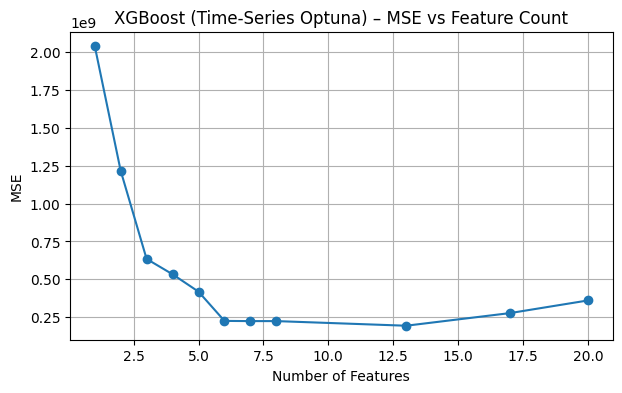

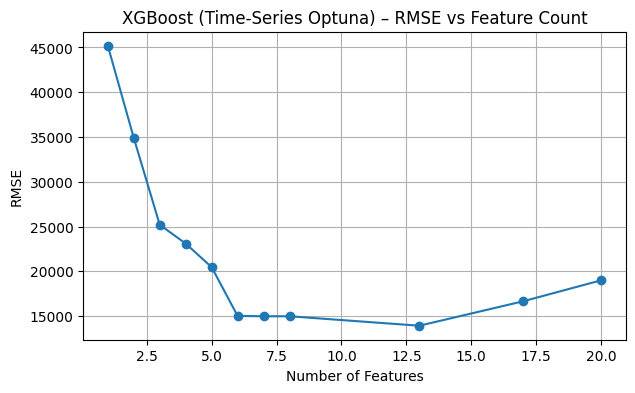

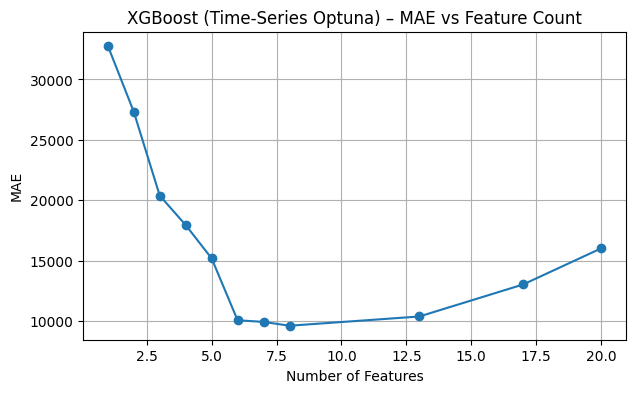

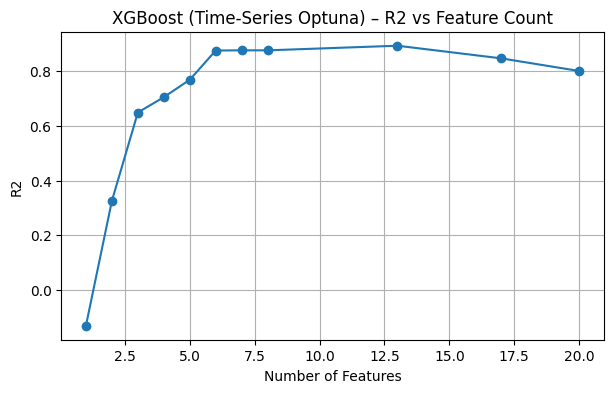

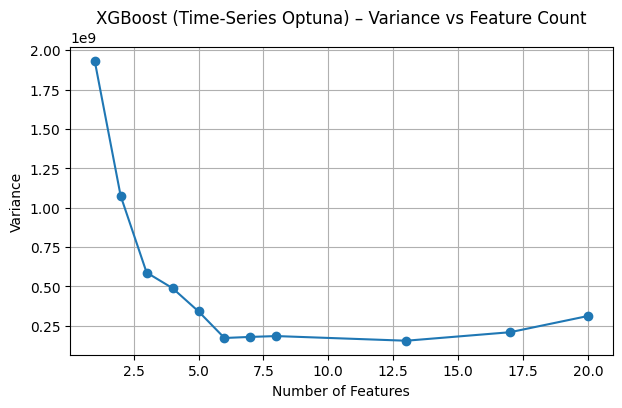

In [ ]:
import optuna
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from xgboost import XGBRegressor
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    r2_score
)
from sklearn.model_selection import TimeSeriesSplit

# --------------------------------------------------------------
# STEP 1 — Optuna Objective (TIME SERIES SAFE)
# --------------------------------------------------------------

def objective(trial):

    params = {
           "n_estimators": trial.suggest_int("n_estimators", 300, 1500),
        "max_depth": trial.suggest_int("max_depth", 2, 10),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
        "gamma": trial.suggest_float("gamma", 0, 5),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
        "reg_alpha": trial.suggest_float("reg_alpha", 0, 5),
        "reg_lambda": trial.suggest_float("reg_lambda", 0, 5),
        "objective": "reg:squarederror",
        "eval_metric": "rmse",
        "tree_method": "hist",
        "random_state": 42,
        "n_jobs": -1
    }

    model = XGBRegressor(**params)

    tscv = TimeSeriesSplit(n_splits=5)
    rmses = []

    for train_idx, val_idx in tscv.split(X_train_sub):
        X_tr = X_train_sub.iloc[train_idx]
        X_val = X_train_sub.iloc[val_idx]
        y_tr = y_train.iloc[train_idx]
        y_val = y_train.iloc[val_idx]

        model.fit(X_tr, y_tr)
        preds = model.predict(X_val)

        rmse = mean_squared_error(y_val, preds)
        rmses.append(rmse)

    return np.mean(rmses)


# --------------------------------------------------------------
# STEP 2 — Loop Through Elbow Points
# --------------------------------------------------------------

results = []

for n in elbow_points:
    print(f"\n========== TUNING FOR TOP {n} FEATURES ==========")

    # ------------------------
    # Select top-N features
    # ------------------------
    top_features = (
        imp_df.sort_values("importance", ascending=False)
              .head(n)["feature"]
              .tolist()
    )

    X_train_sub = X_train[top_features]
    X_test_sub  = X_test[top_features]

    # ------------------------
    # Optuna Study
    # ------------------------
    study = optuna.create_study(direction="minimize", sampler=optuna.samplers.TPESampler(seed=42))
    study.optimize(objective, n_trials=50, show_progress_bar=True)

    print("Best Parameters:", study.best_params)

    # ------------------------
    # Train Final Model
    # (Full training history)
    # ------------------------
    final_model = XGBRegressor(
        **study.best_params,
        objective="reg:squarederror",
        eval_metric="rmse",
        random_state=42,
        n_jobs=-1,
        tree_method="hist"
    )

    final_model.fit(X_train_sub, y_train)

    # ------------------------
    # Test Evaluation
    # ------------------------
    y_pred = final_model.predict(X_test_sub)

    mse  = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae  = mean_absolute_error(y_test, y_pred)
    r2   = r2_score(y_test, y_pred)
    var  = np.var(y_test - y_pred)

    results.append([n, mse, rmse, mae, r2, var])


# --------------------------------------------------------------
# STEP 3 — Metric Table
# --------------------------------------------------------------

metric_df = pd.DataFrame(
    results,
    columns=["Features", "MSE", "RMSE", "MAE", "R2", "Variance"]
)

print("\nFINAL METRIC TABLE:")
print(metric_df)


# --------------------------------------------------------------
# STEP 4 — Plot Metrics
# --------------------------------------------------------------

metrics = ["MSE", "RMSE", "MAE", "R2", "Variance"]

for m in metrics:
    plt.figure(figsize=(7, 4))
    plt.plot(metric_df["Features"], metric_df[m], marker="o")
    plt.xlabel("Number of Features")
    plt.ylabel(m)
    plt.title(f"XGBoost (Time-Series Optuna) – {m} vs Feature Count")
    plt.grid(True)
    plt.show()



# Selected Features

In [ ]:
selected_features = top20['feature'][:13].to_list()

In [ ]:
selected_features

['Total Tourist Arrivals(t-1)',
 'month_December',
 'month_July',
 'month_September',
 'month_May',
 'month_April',
 'Cluster_5(t-1)',
 'month_August',
 'Neutral(t-1)',
 'month_November',
 'Cluster_4(t-1)',
 'Cluster_2(t-1)',
 'Negative(t-1)']

## New X_Train X_Test

In [ ]:
X_train = X_train[selected_features]
X_test = X_test[selected_features]

In [ ]:
X_test.columns

Index(['Total Tourist Arrivals(t-1)', 'month_December', 'month_July',
       'month_September', 'month_May', 'month_April', 'Cluster_5(t-1)',
       'month_August', 'Neutral(t-1)', 'month_November', 'Cluster_4(t-1)',
       'Cluster_2(t-1)', 'Negative(t-1)'],
      dtype='object')

# XGB

In [ ]:
# XGBOOST

# -----------------------------
# objective
# -----------------------------
def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 500),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
        "random_state": 42
    }


    fold_scores = []

    for train_idx, val_idx in tscv.split(X_train):
        X_t, y_t = X_train.iloc[train_idx], y_train.iloc[train_idx]
        X_v, y_v = X_train.iloc[val_idx], y_train.iloc[val_idx]

        model = XGBRegressor(**params)
        model.fit(X_t, y_t)

        pred = model.predict(X_v)
        fold_scores.append(mean_squared_error(y_v, pred))

    return np.mean(fold_scores)
# -----------------------------
# Run optimization
# -----------------------------
study_xgboost = optuna.create_study(direction="minimize",  sampler=optuna.samplers.TPESampler(seed=42))
study_xgboost.optimize(objective, n_trials=100)
best_params_xgboost = study_xgboost.best_params

# -----------------------------
# Fit XGBOOST
# -----------------------------
xgb_model = XGBRegressor(**best_params_xgboost, random_state=42)
xgb_model.fit(X_train, y_train)

pred_xgb = xgb_model.predict(X_test)

# Metrics
# -----------------------------
# TRAIN PREDICTIONS & METRICS
# -----------------------------
train_pred = xgb_model.predict(X_train)

train_mse = mean_squared_error(y_train, train_pred)
train_rmse = np.sqrt(train_mse)
train_mae = mean_absolute_error(y_train, train_pred)
train_mape = mean_absolute_percentage_error(y_train, train_pred)
train_r2 = r2_score(y_train, train_pred)

print("==== TRAIN METRICS ====")
print("Train MSE :", train_mse)
print("Train RMSE:", train_rmse)
print("Train MAE :", train_mae)
print("Train MAPE:", train_mape)
print("Train R²  :", train_r2)

# -----------------------------
# TEST PREDICTIONS & METRICS
# -----------------------------
test_pred = xgb_model.predict(X_test)

test_mse = mean_squared_error(y_test, test_pred)
test_rmse = np.sqrt(test_mse)
test_mae = mean_absolute_error(y_test, test_pred)
test_mape = mean_absolute_percentage_error(y_test, test_pred)
test_r2 = r2_score(y_test, test_pred)

print("\n==== TEST METRICS ====")
print("Test MSE :", test_mse)
print("Test RMSE:", test_rmse)
print("Test MAE :", test_mae)
print("Test MAPE:", test_mape)
print("Test R²  :", test_r2)

[I 2026-02-04 06:06:55,328] A new study created in memory with name: no-name-c8be3cec-e04f-480e-8d7b-6cdb7e29dae7
[I 2026-02-04 06:06:56,559] Trial 0 finished with value: 2141507225.6 and parameters: {'n_estimators': 250, 'max_depth': 10, 'learning_rate': 0.22227824312530747, 'subsample': 0.8394633936788146, 'colsample_bytree': 0.6624074561769746}. Best is trial 0 with value: 2141507225.6.
[I 2026-02-04 06:06:56,823] Trial 1 finished with value: 1436447232.0 and parameters: {'n_estimators': 162, 'max_depth': 3, 'learning_rate': 0.2611910822747312, 'subsample': 0.8404460046972835, 'colsample_bytree': 0.8832290311184181}. Best is trial 1 with value: 1436447232.0.
[I 2026-02-04 06:06:57,213] Trial 2 finished with value: 2001195328.0 and parameters: {'n_estimators': 108, 'max_depth': 10, 'learning_rate': 0.2514083658321223, 'subsample': 0.6849356442713105, 'colsample_bytree': 0.6727299868828402}. Best is trial 1 with value: 1436447232.0.
[I 2026-02-04 06:06:57,520] Trial 3 finished with va

==== TRAIN METRICS ====
Train MSE : 166047.328125
Train RMSE: 407.4890527670651
Train MAE : 310.26971435546875
Train MAPE: 3.163885511114752e+16
Train R²  : 0.9999618530273438

==== TEST METRICS ====
Test MSE : 202325760.0
Test RMSE: 14224.125983694043
Test MAE : 12200.265625
Test MAPE: 0.06652743369340897
Test R²  : 0.8880696296691895


#  Scale X_train, X_test

In [ ]:
month_cols = [col for col in X_train.columns if 'month_' in col]
num_cols = [col for col in X_train.columns if col not in month_cols]

scaler_X = StandardScaler()
scaler_y = StandardScaler()

# scale numeric features
X_train_num_scaled = scaler_X.fit_transform(X_train[num_cols])
X_test_num_scaled = scaler_X.transform(X_test[num_cols])

y_train_scaled = pd.Series(
    scaler_y.fit_transform(y_train.to_numpy().reshape(-1, 1)).flatten(),
    index=y_train.index
)

y_test_scaled = pd.Series(
    scaler_y.transform(y_test.to_numpy().reshape(-1, 1)).flatten(),
    index=y_test.index
)

# add the categorical columns
# Rebuild X_train and X_test as DataFrames
X_train_scaled = pd.DataFrame(
    np.hstack([X_train_num_scaled, X_train[month_cols].values]),
    index=X_train.index,
    columns=num_cols + month_cols
)

X_test_scaled = pd.DataFrame(
    np.hstack([X_test_num_scaled, X_test[month_cols].values]),
    index=X_test.index,
    columns=num_cols + month_cols
)


# SVR

In [ ]:

# =============================
# SVR Objective Function
# =============================
def objective_svr(trial):

    params = {
        "C": trial.suggest_float("C", 0.1, 100.0, log=True),
        "epsilon": trial.suggest_float("epsilon", 0.001, 1.0, log=True),
        "gamma": trial.suggest_categorical("gamma", ["scale", "auto"]),
        "kernel": trial.suggest_categorical("kernel", ["rbf", "poly", "sigmoid"])
    }

    fold_scores = []

    for train_idx, val_idx in tscv.split(X_train_scaled):

        X_t = X_train_scaled.iloc[train_idx]
        X_v = X_train_scaled.iloc[val_idx]

        y_t = y_train_scaled.iloc[train_idx]
        y_v = y_train_scaled.iloc[val_idx]

        model = SVR(**params)
        model.fit(X_t, y_t)

        preds = model.predict(X_v)
        fold_scores.append(mean_squared_error(y_v, preds))

    return np.mean(fold_scores)



# =============================
# RUN OPTUNA
# =============================
study_svr = optuna.create_study(
    direction="minimize",
    sampler=optuna.samplers.TPESampler(seed=42)
)

study_svr.optimize(objective_svr, n_trials=100)
best_params_svr = study_svr.best_params



# =============================
# FIT FINAL SVR MODEL
# =============================
svr_model = SVR(**best_params_svr)
svr_model.fit(X_train_scaled, y_train_scaled)

# Train predictions
train_pred_scaled = svr_model.predict(X_train_scaled)
train_pred = scaler_y.inverse_transform(train_pred_scaled.reshape(-1, 1)).flatten()

# Test predictions
test_pred_scaled = svr_model.predict(X_test_scaled)
test_pred = scaler_y.inverse_transform(test_pred_scaled.reshape(-1, 1)).flatten()


print("==== SVR TRAIN METRICS ====")
print("Train RMSE:", np.sqrt(mean_squared_error(y_train, train_pred)))
print("Train MAE :", mean_absolute_error(y_train, train_pred))
print("Train MAPE:", mean_absolute_percentage_error(y_train, train_pred))
print("Train R²  :", r2_score(y_train, train_pred))

print("\n==== SVR TEST METRICS ====")
print("Test RMSE:", np.sqrt(mean_squared_error(y_test, test_pred)))
print("Test MAE :", mean_absolute_error(y_test, test_pred))
print("Test MAPE:", mean_absolute_percentage_error(y_test, test_pred))
print("Test R²  :", r2_score(y_test, test_pred))




[I 2026-02-04 06:08:02,653] A new study created in memory with name: no-name-fbc1eb8b-01b7-4632-95b8-57cbedf55dcd
[I 2026-02-04 06:08:02,680] Trial 0 finished with value: 0.7701109555848074 and parameters: {'C': 1.3292918943162166, 'epsilon': 0.711447600934342, 'gamma': 'scale', 'kernel': 'rbf'}. Best is trial 0 with value: 0.7701109555848074.
[I 2026-02-04 06:08:02,727] Trial 1 finished with value: 0.39572677882093676 and parameters: {'C': 39.67605077052987, 'epsilon': 0.06358358856676251, 'gamma': 'scale', 'kernel': 'rbf'}. Best is trial 1 with value: 0.39572677882093676.
[I 2026-02-04 06:08:02,759] Trial 2 finished with value: 0.3528626798566381 and parameters: {'C': 0.3511356313970407, 'epsilon': 0.0035498788321965025, 'gamma': 'auto', 'kernel': 'sigmoid'}. Best is trial 2 with value: 0.3528626798566381.
[I 2026-02-04 06:08:02,793] Trial 3 finished with value: 0.43152031601566837 and parameters: {'C': 0.262108787826544, 'epsilon': 0.007523742884534853, 'gamma': 'auto', 'kernel': 'r

==== SVR TRAIN METRICS ====
Train RMSE: 8053.484515384688
Train MAE : 5483.421857980923
Train MAPE: 5.5427547485839245e+17
Train R²  : 0.9850940500142313

==== SVR TEST METRICS ====
Test RMSE: 13402.892786843508
Test MAE : 10728.623885904373
Test MAPE: 0.05739841603495368
Test R²  : 0.9006211595864452


In [ ]:
X_train_scaled.shape

(224, 13)

# ANN

In [ ]:
def objective_ann(trial):

    params = {
        "hidden1": trial.suggest_int("hidden1", 16, 128),
        "hidden2": trial.suggest_int("hidden2", 16, 128),
        "lr": trial.suggest_float("lr", 1e-4, 1e-2, log=True),
        "alpha": trial.suggest_float("alpha", 1e-5, 1e-2, log=True)
    }

    tscv = TimeSeriesSplit(n_splits=5)
    fold_scores = []

    for train_idx, val_idx in tscv.split(X_train_scaled):

        X_t = X_train_scaled.iloc[train_idx]
        X_v = X_train_scaled.iloc[val_idx]

        y_t = y_train_scaled.iloc[train_idx]
        y_v = y_train_scaled.iloc[val_idx]

        model = MLPRegressor(
            hidden_layer_sizes=(params["hidden1"], params["hidden2"]),
            learning_rate_init=params["lr"],
            alpha=params["alpha"],
            max_iter=500,
            random_state=42
        )

        model.fit(X_t, y_t)

        preds_scaled = model.predict(X_v)

        preds = scaler_y.inverse_transform(
            preds_scaled.reshape(-1, 1)
        ).flatten()

        y_val = scaler_y.inverse_transform(
            y_v.to_numpy().reshape(-1, 1)
        ).flatten()

        fold_scores.append(mean_squared_error(y_val, preds))

    return np.mean(fold_scores)



# -----------------------------
# Run Optuna
# -----------------------------
study_ann = optuna.create_study(direction="minimize", sampler=optuna.samplers.TPESampler(seed=42))
study_ann.optimize(objective_ann, n_trials=100)
best_params_ann = study_ann.best_params

# -----------------------------
# Fit final ANN model
# -----------------------------
ann_model = MLPRegressor(
    hidden_layer_sizes=(best_params_ann["hidden1"], best_params_ann["hidden2"]),
    learning_rate_init=best_params_ann["lr"],
    alpha=best_params_ann["alpha"],
    random_state=42,
    max_iter=500
)
ann_model.fit(X_train_scaled, y_train_scaled)

# -----------------------------
# Predictions (rescale to original target)
# -----------------------------
train_pred_scaled = ann_model.predict(X_train_scaled)
train_pred = scaler_y.inverse_transform(train_pred_scaled.reshape(-1, 1)).flatten()

test_pred_scaled = ann_model.predict(X_test_scaled)
test_pred = scaler_y.inverse_transform(test_pred_scaled.reshape(-1, 1)).flatten()

# -----------------------------
# Metrics
# -----------------------------
print("==== TRAIN METRICS ====")
print("Train RMSE:", np.sqrt(mean_squared_error(y_train, train_pred)))
print("Train MAE :", mean_absolute_error(y_train, train_pred))
print("Train MAPE:", mean_absolute_percentage_error(y_train, train_pred))
print("Train R²  :", r2_score(y_train, train_pred))

print("\n==== TEST METRICS ====")
print("Test RMSE:", np.sqrt(mean_squared_error(y_test, test_pred)))
print("Test MAE :", mean_absolute_error(y_test, test_pred))
print("Test MAPE:", mean_absolute_percentage_error(y_test, test_pred))
print("Test R²  :", r2_score(y_test, test_pred))



[I 2026-02-04 06:08:08,019] A new study created in memory with name: no-name-dc6227db-b94d-4887-a46b-2037ef7cfb65
[I 2026-02-04 06:08:08,604] Trial 0 finished with value: 749411031.5000532 and parameters: {'hidden1': 58, 'hidden2': 123, 'lr': 0.0029106359131330704, 'alpha': 0.0006251373574521745}. Best is trial 0 with value: 749411031.5000532.
[I 2026-02-04 06:08:10,242] Trial 1 finished with value: 2167698596.055001 and parameters: {'hidden1': 33, 'hidden2': 33, 'lr': 0.00013066739238053285, 'alpha': 0.003967605077052989}. Best is trial 0 with value: 749411031.5000532.
[I 2026-02-04 06:08:13,043] Trial 2 finished with value: 1390535262.8811555 and parameters: {'hidden1': 83, 'hidden2': 96, 'lr': 0.00010994335574766199, 'alpha': 0.008123245085588688}. Best is trial 0 with value: 749411031.5000532.
[I 2026-02-04 06:08:14,261] Trial 3 finished with value: 1219078695.9963894 and parameters: {'hidden1': 110, 'hidden2': 39, 'lr': 0.0002310201887845295, 'alpha': 3.5498788321965036e-05}. Best

==== TRAIN METRICS ====
Train RMSE: 7184.436811072277
Train MAE : 4858.416667157614
Train MAPE: 2.9162291063751475e+17
Train R²  : 0.9881374662095973

==== TEST METRICS ====
Test RMSE: 13665.90936890197
Test MAE : 11364.752169478501
Test MAPE: 0.061882307785052
Test R²  : 0.8966824949347287


# LSTM

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
import optuna

# -----------------------------
# RESHAPE FOR LSTM
# (timesteps = 1, features = n_features)
# -----------------------------
X_train_lstm = X_train_scaled.values.reshape(
    (X_train_scaled.shape[0], 1, X_train_scaled.shape[1])
)
X_test_lstm = X_test_scaled.values.reshape(
    (X_test_scaled.shape[0], 1, X_test_scaled.shape[1])
)

# -----------------------------
# OPTUNA OBJECTIVE FUNCTION
# -----------------------------
def objective_lstm(trial):

    tf.keras.backend.clear_session()

    n_units = trial.suggest_int("n_units", 1, 64)
    dropout = trial.suggest_float("dropout", 0.0, 0.4)
    lr = trial.suggest_float("lr", 1e-4, 1e-2, log=True)
    batch_size = trial.suggest_categorical("batch_size", [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,13])
    epochs = 60

    fold_losses = []

    for train_idx, val_idx in tscv.split(X_train_lstm):

        X_t, X_v = X_train_lstm[train_idx], X_train_lstm[val_idx]
        y_t, y_v = y_train_scaled.iloc[train_idx], y_train_scaled.iloc[val_idx]

        model = Sequential([
            Input(shape=(X_t.shape[1], X_t.shape[2])),
            LSTM(n_units),
            Dropout(dropout),
            Dense(1)
        ])

        model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
            loss="mse"
        )

        callbacks = [
            EarlyStopping(
                monitor="val_loss",
                patience=10,
                restore_best_weights=True
            )
        ]

        model.fit(
            X_t, y_t,
            validation_data=(X_v, y_v),
            epochs=epochs,
            batch_size=batch_size,
            callbacks=callbacks,
            verbose=0
        )

        preds = model.predict(X_v, verbose=0)
        fold_losses.append(mean_squared_error(y_v, preds))

    return np.mean(fold_losses)

# -----------------------------
# RUN OPTUNA
# -----------------------------
study_lstm = optuna.create_study(
    direction="minimize",
    sampler=optuna.samplers.TPESampler(seed=42)
)

study_lstm.optimize(objective_lstm, n_trials=20)

best_params_lstm = study_lstm.best_params
print("Best LSTM Params:", best_params_lstm)

# -----------------------------
# FINAL LSTM MODEL
# -----------------------------
tf.keras.backend.clear_session()

lstm_model = Sequential([
    Input(shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])),
    LSTM(best_params_lstm["n_units"]),
    Dropout(best_params_lstm["dropout"]),
    Dense(1)
])

lstm_model.compile(
    optimizer=tf.keras.optimizers.Adam(
        learning_rate=best_params_lstm["lr"]
    ),
    loss="mse"
)

final_callbacks = [
    EarlyStopping(
        monitor="loss",
        patience=10,
        restore_best_weights=True
    )
]

lstm_model.fit(
    X_train_lstm,
    y_train_scaled,
    epochs=80,
    batch_size=best_params_lstm["batch_size"],
    callbacks=final_callbacks,
    verbose=1
)

# -----------------------------
# PREDICTIONS & INVERSE SCALE
# -----------------------------
train_pred_scaled = lstm_model.predict(X_train_lstm)
test_pred_scaled = lstm_model.predict(X_test_lstm)

train_pred = scaler_y.inverse_transform(train_pred_scaled).ravel()
test_pred = scaler_y.inverse_transform(test_pred_scaled).ravel()

# -----------------------------
# TRAIN METRICS
# -----------------------------
train_mse = mean_squared_error(y_train, train_pred)
train_rmse = np.sqrt(train_mse)
train_mae = mean_absolute_error(y_train, train_pred)
train_mape = mean_absolute_percentage_error(y_train, train_pred)
train_r2 = r2_score(y_train, train_pred)

print("\n==== LSTM TRAIN METRICS ====")
print(f"MSE  : {train_mse:.4f}")
print(f"RMSE : {train_rmse:.4f}")
print(f"MAE  : {train_mae:.4f}")
print(f"MAPE : {train_mape:.4f}")
print(f"R²   : {train_r2:.4f}")

# -----------------------------
# TEST METRICS
# -----------------------------
test_mse = mean_squared_error(y_test, test_pred)
test_rmse = np.sqrt(test_mse)
test_mae = mean_absolute_error(y_test, test_pred)
test_mape = mean_absolute_percentage_error(y_test, test_pred)
test_r2 = r2_score(y_test, test_pred)

print("\n==== LSTM TEST METRICS ====")
print(f"MSE  : {test_mse:.4f}")
print(f"RMSE : {test_rmse:.4f}")
print(f"MAE  : {test_mae:.4f}")
print(f"MAPE : {test_mape:.4f}")
print(f"R²   : {test_r2:.4f}")


[I 2026-02-04 06:09:19,077] A new study created in memory with name: no-name-5bc2d0a1-ebb7-4470-bc1e-7606114fe370
[I 2026-02-04 06:10:04,096] Trial 0 finished with value: 0.17889646047566177 and parameters: {'n_units': 24, 'dropout': 0.3802857225639665, 'lr': 0.0029106359131330704, 'batch_size': 10}. Best is trial 0 with value: 0.17889646047566177.
[I 2026-02-04 06:10:57,283] Trial 1 finished with value: 0.31175380133524616 and parameters: {'n_units': 12, 'dropout': 0.1216968971838151, 'lr': 0.0011207606211860567, 'batch_size': 9}. Best is trial 0 with value: 0.17889646047566177.
[I 2026-02-04 06:11:56,272] Trial 2 finished with value: 0.585119353645457 and parameters: {'n_units': 39, 'dropout': 0.06820964947491662, 'lr': 0.00013492834268013249, 'batch_size': 3}. Best is trial 0 with value: 0.17889646047566177.
[I 2026-02-04 06:12:58,457] Trial 3 finished with value: 0.1725579205482876 and parameters: {'n_units': 43, 'dropout': 0.12468443043576438, 'lr': 0.001096821720752952, 'batch_si

Best LSTM Params: {'n_units': 53, 'dropout': 0.0859238393756302, 'lr': 0.00527150638805699, 'batch_size': 2}
Epoch 1/80
112/112 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.5977
Epoch 2/80
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0855
Epoch 3/80
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0685
Epoch 4/80
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0667
Epoch 5/80
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0605
Epoch 6/80
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0491
Epoch 7/80
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0569
Epoch 8/80
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0501
Epoch 9/80
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0450
Epoch 10/80
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0505
Epoch 11/80
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0472
Epoch 12/80
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0427
Epoch 13/80
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0438
Epoch 14/80
112/